In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
src_train_parquet = 'ke_test_data/train.parquet'
src_test_parquet = 'ke_test_data/test.parquet'
src_categories_tree = 'ke_test_data/categories_tree.csv'

In [3]:
categories_tree = pd.read_csv(src_categories_tree)
categories_tree.shape

(3370, 3)

In [4]:
categories_tree.sample(10)

,id,title,parent_id
1884,12766,Автосигнализации,10111
484,10195,Кондиционеры,10029
986,11751,Аксессуары для сумок,10060
1117,11900,Защита шин и дисков,10428
2076,12987,Формы для яичницы,10651
1444,12272,Трусы,10937
2541,13513,Автозагар,10626
2562,13537,"Носки, пинетки",10095
2694,13684,Платья вечерние,10597
2692,13682,Кроссовки,10550


In [5]:
# любое дерево - граф, просто направленный, обычно с одинм root'ом
import networkx as nx
DG = nx.DiGraph()
G = nx.Graph()  #  костыль, т.к. для направленного графа не рисует деревья. Not Implemented

for k, v in tqdm(categories_tree.iterrows()):
    DG.add_edge(v['parent_id'], v['id'], weight=1)
    G.add_edge(v['parent_id'], v['id'], weight=1)

print("Всего уникальных вершин: {0}".format(len(DG.nodes)))

3370it [00:00, 14371.91it/s]

Всего уникальных вершин: 3373


In [6]:
def all_predcestors(g, id, max_len=6):
    # циклично запрашиваем предков, пока их не будет совсем
    all_preds = [id]
    while True:
        preds = list(g.predecessors(id))
        if len(preds) == 0:
            break
        all_preds.append(preds[0])
        id = all_preds[-1]

    # доводим до максимального размера, чтобы вмещалось в tensor/array
    # паддинг -1 (0 занят нашим каталогом, мы позже их закодируем, но всеравно...)
#     if len(all_preds) < max_len:
#         all_preds = [-1] * (max_len - len(all_preds)) + all_preds
    return all_preds[::-1]


In [7]:
all_predcestors(DG, 12696)

[0, 1, 10020, 10030, 12696]

In [8]:
all_predcestors(DG, 12625)

[0, 1, 10014, 10116, 11116, 12625]

In [9]:
all_predcestors(DG, 1)

[0, 1]

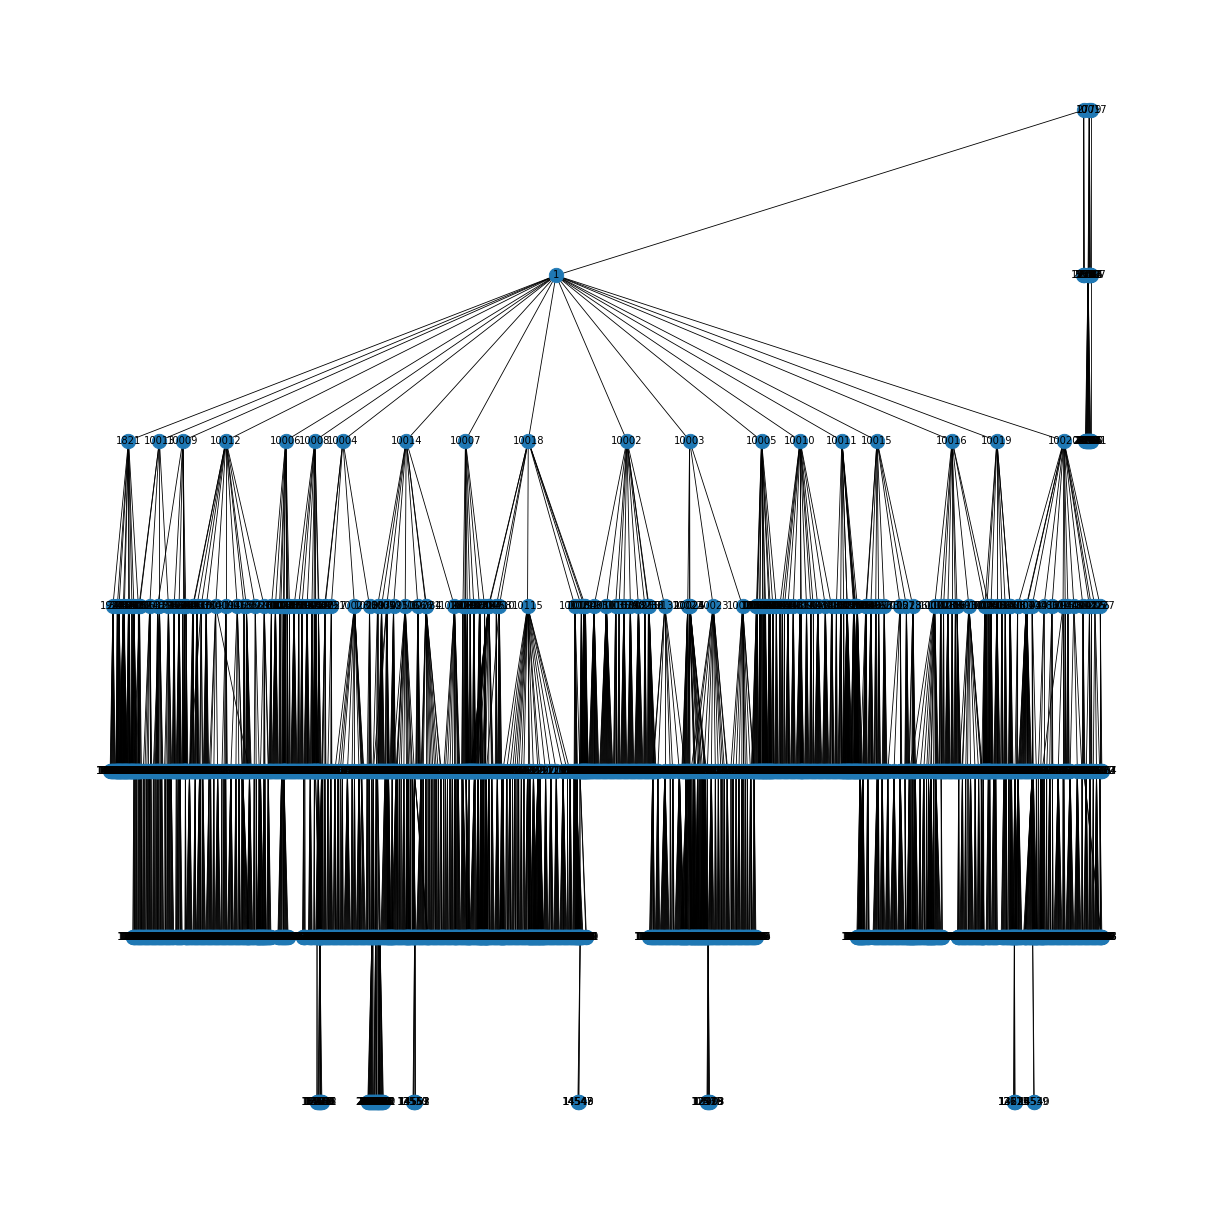

In [10]:
# Посмотрим на все дерево каталогов
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.maximum_spanning_tree(G)
plt.figure(figsize=(20,20), dpi=60)
pos = graphviz_layout(T, prog="dot")
top = 500
step = 50
first_pad = 50
new_pos = {}
for k, v in pos.items():
    v1, v2 = v
    v2 = top - (len(all_predcestors(DG, k)) * step + first_pad)
    new_pos[k] = (v1, v2)

nx.draw(T, new_pos, with_labels=True, font_weight='normal')
plt.show()

In [11]:
train = pq.read_table(src_train_parquet).to_pandas()
train.shape

(283452, 7)

In [12]:
# Посмотрим на дерево каталогов только с категориями из учебного сета
train_catalogs = set()
for cat in train['category_id']:
    train_catalogs.update(set(all_predcestors(DG, cat)))

catalog_cnt = len(train_catalogs)
print(f'в обучении будем использовать {catalog_cnt} категорий')

в обучении будем использовать 1477 категорий


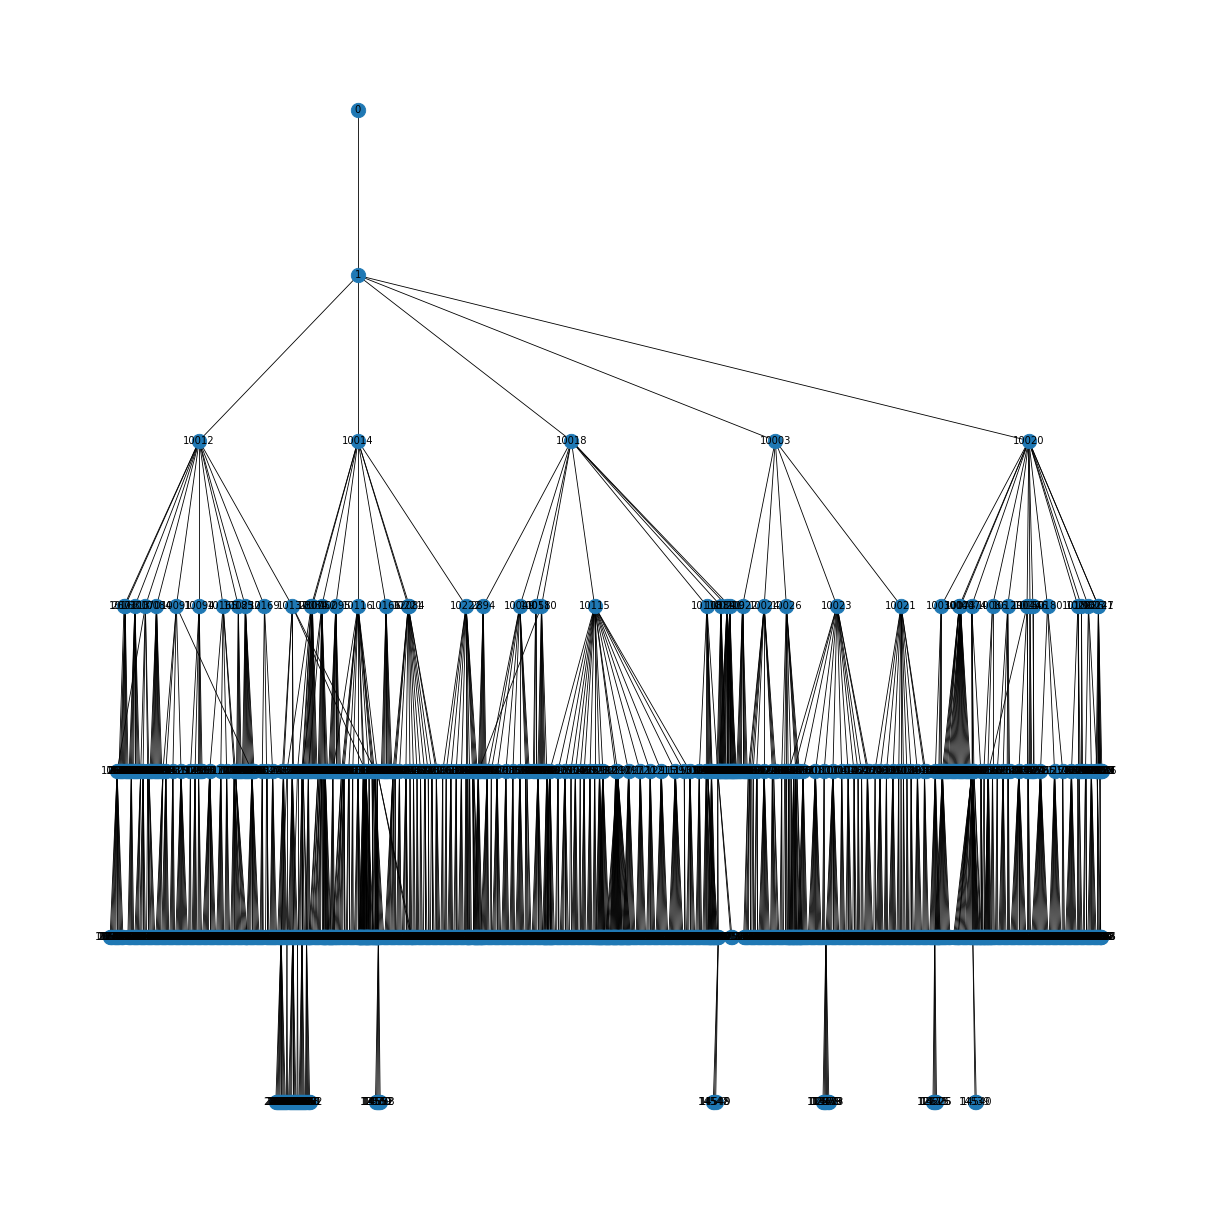

In [13]:
# Взглянем только на дерево каталогов, которые мы увидем в трейн сете.
for node in list(G.nodes):
    if node not in train_catalogs:
        try: G.remove_node(node)
        except: pass

T = nx.maximum_spanning_tree(G)
plt.figure(figsize=(20,20), dpi=60)
pos = graphviz_layout(T, prog="dot")

top = 500
step = 50
first_pad = 50
new_pos = {}
for k, v in pos.items():
    v1, v2 = v
    v2 = top - (len(all_predcestors(DG, k)) * step + first_pad)
    new_pos[k] = (v1, v2)

nx.draw(T, new_pos, with_labels=True, font_weight='normal')
plt.show()    


In [14]:
test = pq.read_table(src_test_parquet).to_pandas()
test.shape

(70864, 6)

In [15]:
train.sample(5)

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
23473,1301173,"Значки ""Dota 2""",None,None,0.0,0,12159
68382,741874,Аккумулятор никель-металлгидридный Ni-MH AA 30...,None,None,5.0,1,12964
242042,1377505,Кружевной комплект белья,None,None,0.0,0,12657
271867,613356,Кулон-подвеска мусульманский с первыми пятью а...,Кулон-подвеска мусульманский с сурами корана ж...,None,0.0,0,12579
102119,672050,Ремень для часов из натуральной кожи A-1760PKS...,Эта модель на складе почти закончилась,РАЗМЕР:26 мм.,0.0,0,2867


In [16]:
# Смотрим, сколько реальных категорий используется в трейн сете
train_catalogs = set()
for cat in train['category_id']:
    train_catalogs.update(set(all_predcestors(DG, cat)))
train_catalogs = sorted(list(train_catalogs))

train_cat2id = {}
for i, cat in enumerate(train_catalogs):
    train_cat2id[cat] = i

catalog_cnt = len(train_catalogs)
print(f'в обучении будем использовать {catalog_cnt} категорий')

в обучении будем использовать 1477 категорий


In [17]:
dataset_dublicates = train.groupby(['id'])\
    .agg({'title': 'count'})\
    .title.max()

print('Максимальное колличество повторений id в датасете: {0}'.format(dataset_dublicates))

Максимальное колличество повторений id в датасете: 1


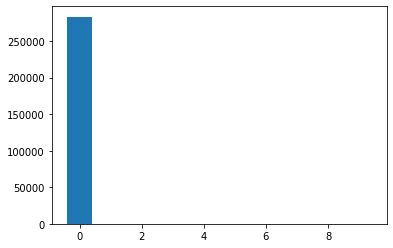

Колличество оценок проставлено на всю номенклатуру: 0.04 %


In [18]:
hist_votes = np.histogram(train.feedback_quantity, bins=10)[0]
plt.bar(range(len(hist_votes)), hist_votes)
plt.show()

voted = sum(hist_votes[1:]) / sum(hist_votes) * 100
print('Колличество оценок проставлено на всю номенклатуру: {0:.2f} %'.format(voted))

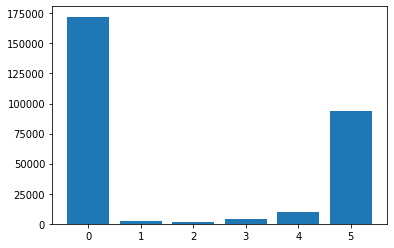

Столько оценок проставлено на всю номенклатуру:
~0 :60.74 %
~1 :0.85 %
~2 :0.46 %
~3 :1.39 %
~4 :3.39 %
~5 :33.17 %


In [19]:
hist_rating = np.histogram(train['rating'], bins=6)
plt.bar(range(len(hist_rating[0])), hist_rating[0])
plt.show()

cnt_ratings = sum(hist_rating[0])

print("""Столько оценок проставлено на всю номенклатуру:
~0 :{0:.2f} %
~1 :{1:.2f} %
~2 :{2:.2f} %
~3 :{3:.2f} %
~4 :{4:.2f} %
~5 :{5:.2f} %""".format(hist_rating[0][0] / cnt_ratings * 100,
                        hist_rating[0][1] / cnt_ratings * 100,
                        hist_rating[0][2] / cnt_ratings * 100,
                        hist_rating[0][3] / cnt_ratings * 100,
                        hist_rating[0][4] / cnt_ratings * 100,
                        hist_rating[0][5] / cnt_ratings * 100,)
      )

In [20]:
train['text'] = train['title'].astype(str) + ' ' + train['short_description'].astype(str) + ' ' + train['name_value_characteristics'].astype(str)
# train = train.drop(['title', 'short_description', 'name_value_characteristics'], axis=1)
train.sample(5)

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id,text
28833,250352,Сувенир настольные гелевые часы,None,None,5.000000,4,11617,Сувенир настольные гелевые часы None None
250055,994422,Ёлка искусственная с шишками,None,Высота:150 см|180 см|210 см,4.250000,4,14265,Ёлка искусственная с шишками None Высота:150 с...
259075,243214,Браслет,Брвслет с бусинками жемчуг. В золотом цвете.,None,4.500000,2,11574,Браслет Брвслет с бусинками жемчуг. В золотом ...
84139,32624,"Леггинсы, лосины женские",Леггинсы из быстросохнущей влагоотводящей ткан...,None,3.952381,42,13220,"Леггинсы, лосины женские Леггинсы из быстросох..."
127886,1310615,"Свитер женский повседневный ""Кейт""",свитер женский / свитер повседневный / свитер ...,None,0.000000,0,13511,"Свитер женский повседневный ""Кейт"" свитер женс..."


In [21]:
from collections import Counter
import re

regex = r"[\s\|$:*!?#:,.(){}\"\'\$\^\/\\\[\]\-+”“%¡¿&;«»`\d]"

word_cnt = dict(Counter([y for x in train['text'].values.flatten() for y in re.split(regex, x.lower())]))

print('Всего разных слов {}'.format(len(word_cnt)))

Всего разных слов 89840


In [22]:
word_cnt

{'muhle': 113,
 'manikure': 113,
 'песочные': 85,
 'колпачки': 87,
 'для': 173436,
 'педикюра': 1230,
 '': 2387070,
 'pw': 13,
 'средний': 197,
 'грит': 216,
 'упаковка': 1450,
 'шт': 18230,
 'колпачок': 47,
 'песочный': 44,
 'шлифовальный': 9,
 'белый': 3723,
 'none': 385106,
 'sony': 762,
 'xperia': 308,
 'l': 5010,
 'защитное': 8145,
 'стекло': 10229,
 'd': 7287,
 'конверт': 1370,
 'денег': 1383,
 'прекрасная': 81,
 'роза': 725,
 'х': 26652,
 'см': 40382,
 '×': 1307,
 'серьги': 10267,
 'наклейки': 2461,
 'на': 43092,
 'унитаз': 46,
 'туалета': 232,
 'крышку': 65,
 'бачок': 8,
 'дверь': 135,
 'ванную': 187,
 'стену': 695,
 'мебель': 44,
 'зеркало': 539,
 'водостойкая': 262,
 'интересная': 29,
 'наклейка': 1100,
 'размер': 28768,
 'многослойное': 142,
 'колье': 1037,
 'замок': 237,
 'и': 70030,
 'ключик': 91,
 'машинка': 609,
 'удаления': 696,
 'катышек': 40,
 'спортивный': 1499,
 'костюм': 4508,
 'весну': 148,
 'детский': 3622,
 'с': 90271,
 'начесом': 741,
 'тёплый': 98,
 'флисе': 3

In [23]:
# Смотрим частотку в виде сортированной таблицы
word_cnt_df = pd.DataFrame.from_dict(word_cnt, orient='index', columns=['cnt'])\
    .sort_values(by='cnt', ascending=False)\
    .reset_index()\
    .rename({'index': 'word'}, axis = 1)
word_cnt_df.head(20)

,word,cnt
0,,2387070
1,none,385106
2,для,173436
3,с,90271
4,и,70030
5,на,43092
6,см,40382
7,в,38970
8,размер,28768
9,х,26652


In [25]:
# Смтрим частотку с длинной слов больше 3
word_cnt_df['len'] = word_cnt_df['word'].apply(lambda x: len(str(x)))
word_cnt_df = word_cnt_df[word_cnt_df['len'] >= 3]
print('в векторайзер/энкодер примерно попадет {0} слов'.format(len(word_cnt_df)))
word_cnt_df.head(20)



в векторайзер/энкодер примерно попадет 88593 слов


,word,cnt,len
1,none,385106,4
2,для,173436,3
8,размер,28768,6
13,iphone,21717,6
14,чехол,20566,5
15,набор,19574,5
16,носки,18971,5
17,pro,18838,3
20,волос,17589,5
21,женские,12330,7
